In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

from core.data import load_records
from core.transformer import ASTROMER
from core.scheduler import CustomSchedule
from core.callbacks import get_callbacks
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

In [2]:
# Hyperparameters
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1
exp_path = "./experiments/test"
root_data = './data/records/macho'
EPOCHS = 20
BATCHSIZE = 16

In [3]:
train_batches, val_batches = load_records(root_data, BATCHSIZE)

In [4]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

# Loss Function
cls_loss_object = BinaryCrossentropy(from_logits=True, reduction='none')
rec_loss_object = MeanSquaredError(reduction='none')

# Metrics
transformer = ASTROMER(num_layers=num_layers,
                              d_model=d_model,
                              num_heads=num_heads,
                              dff=dff,
                              pe_input=1000,
                              rate=0.1)

transformer.model(BATCHSIZE).summary()


transformer.compile(optimizer=optimizer, 
                    cls_loss=cls_loss_object,
                    rec_loss=rec_loss_object,
                    metrics=[rec_loss_object])
transformer.evaluate(train_batches.take(1))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(16, 202, 2)]       0                                            
__________________________________________________________________________________________________
Mask (InputLayer)               [(16, 1, 202, 202)]  0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (16, 202, 512)       18915840    Input[0][0]                      
                                                                 Mask[0][0]                       
__________________________________________________________________________________________________
dense_37 (Dense)                (16, 202, 1)         513         encoder[0][0]                

65.01824188232422

In [20]:
expdir = '{}/train_model.h5'.format(exp_path)
transformer.load_weights(expdir)
transformer.evaluate(train_batches)

67/67 [==============================] - 62s 926ms/step - mean_squared_error: 0.8288


0.8288111090660095

In [6]:
rec_pred, rec_true, cls_pred, cls_true = transformer.predict(train_batches.take(1))

In [11]:
label_pred = cls_pred
softmax = tf.exp(label_pred) / tf.reduce_sum(tf.exp(label_pred), 1)
label_pred = tf.where(softmax<0.5, 0, 1)

In [8]:
plt.style.use('dark_background')

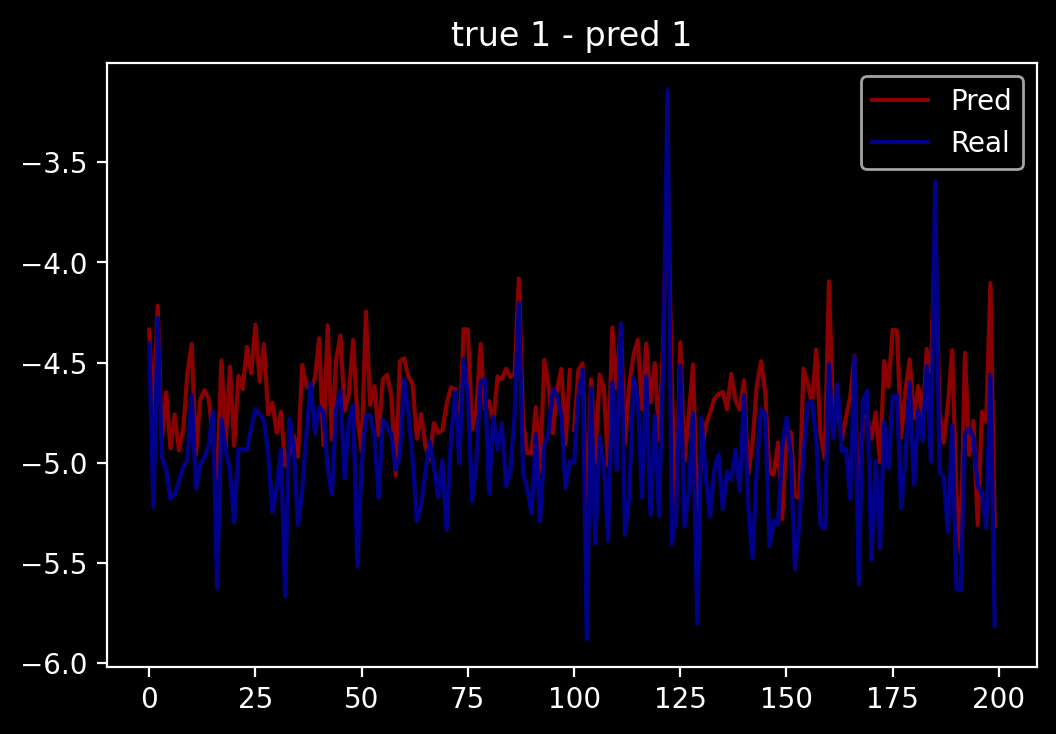

In [19]:
n = 2
for n in range(1):
    plt.figure(dpi=200)
    y_pred = rec_pred[n]
    y_true = rec_true[n]
    l_pred = label_pred[n]
    l_true = cls_true[n]

    x_time = tf.range(100)
    
    plt.plot(x_time, y_pred[:100], color='darkred', label='Pred')
    plt.plot(x_time, y_true[:100], color='darkblue', linestyle='-', label='Real')
    
    plt.plot(x_time+100, y_pred[101:], color='darkred')
    plt.plot(x_time+100, y_true[101:], color='darkblue', marker='',linestyle='-')
    plt.title('true {:.0f} - pred {}'.format(l_true[0],l_pred.numpy()[0][0]))
    plt.legend()
    plt.show()